In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 
from multiprocessing import Pool
from scipy.signal import argrelextrema

In [3]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area_t = pd.read_csv(f"data/area/area_t.csv").drop(columns=['Unnamed: 0','Unnamed: 0.1'])
df_area_features = pd.read_csv(f"data/area_features/Area_features.csv").drop(columns=['Unnamed: 0'])
#playIds = df_area.playId.unique()

In [4]:
print(df_area_t.head())

   frameId      Area  playId      gameId
0        1  22.31990      97  2021090900
1        2  22.16275      97  2021090900
2        3  22.16015      97  2021090900
3        4  22.45335      97  2021090900
4        5  22.72785      97  2021090900


In [5]:
print(df_area_features.head())

   playId      gameId  event  te         Ae  tc         Ac  tsnap
0      97  2021090900  hurry  35  12.237518  32  15.013121      5
1     137  2021090900   pass  26  16.305513  16  26.760950      6
2     187  2021090900   pass  23  18.312900  15  25.935250      5
3     282  2021090900   pass  33  29.901092  30  36.001815      5
4     349  2021090900  hurry  27  14.784734  13  24.298700      6


# Limit area for scramble occurence

In [6]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "(event == 'scramble' | event == 'sack')"
scramble_plays = df_area_features.query(scramble_mask)
scramble_plays = pd.merge(scramble_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of scramble or sack plays : {len(scramble_plays)}')
scramble_plays_wo_PA = scramble_plays[scramble_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(scramble_plays_wo_PA)}')
print(scramble_plays_wo_PA.head())


Total n° of plays : 8557
n° of scramble or sack plays : 1815
n° of scramble or sack plays w/o play action : 1139
   playId      gameId     event  te         Ae  tc        Ac  tsnap  \
2     947  2021090900  scramble  32   6.471160  13  23.76425      5   
6    2032  2021090900  scramble  33  13.483074  28  17.20230      5   
7    2279  2021090900  scramble  30   8.196493  12  21.51920      5   
8    2298  2021090900  scramble  36   4.706347  18  27.39720      5   
9    2330  2021090900  scramble  37  23.306400  17  24.66465      5   

                                     playDescription  quarter  ...  \
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
6  (2:45) (No Huddle, Shotgun) T.Brady pass deep ...        2  ...   
7  (1:11) (Shotgun) D.Prescott sacked at TB 33 fo...        2  ...   
8  (:35) (No Huddle, Shotgun) D.Prescott scramble...        2  ...   
9  (:28) (Shotgun) D.Prescott scrambles left end ...        2  ...   

   foulNFLId3  absoluteYardlineNumber o

In [7]:
scramble_plays["Acrit"] = np.nan
for scramble_id in tqdm(scramble_plays.index):

    scramble_play = scramble_plays.loc[scramble_id].playId
    scramble_game = scramble_plays.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays.head())
print(scramble_plays.Acrit.mean())
print(scramble_plays.Acrit.std())


100%|██████████| 1815/1815 [00:02<00:00, 706.12it/s]

   playId      gameId     event  te         Ae  tc         Ac  tsnap  \
0     735  2021090900  scramble  35  49.791600  34  49.794450      5   
1     764  2021090900  scramble  22  24.175115  19  26.277012      6   
2     947  2021090900  scramble  32   6.471160  13  23.764250      5   
3    1312  2021090900  scramble  19  28.861884  18  27.105112      5   
4    1425  2021090900  scramble  25  32.751879  19  42.508076      6   

                                     playDescription  quarter  ...  \
0  (2:45) (Shotgun) D.Prescott pass short right t...        1  ...   
1  (2:22) (No Huddle) D.Prescott pass short right...        1  ...   
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
3  (9:53) T.Brady pass short right to R.Gronkowsk...        2  ...   
4  (9:04) D.Prescott pass short right to B.Jarwin...        2  ...   

   absoluteYardlineNumber  offenseFormation        personnelO defendersInBox  \
0                    47.0           SHOTGUN  1 RB, 1 TE, 3 WR     

In [8]:
scramble_plays_wo_PA["Acrit"] = np.nan
print(len(scramble_plays_wo_PA))
for scramble_id in tqdm(scramble_plays_wo_PA.index):

    scramble_play = scramble_plays_wo_PA.loc[scramble_id].playId
    scramble_game = scramble_plays_wo_PA.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays_wo_PA.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays_wo_PA.head())
print(scramble_plays_wo_PA.Acrit.mean())
print(scramble_plays_wo_PA.Acrit.std())

/tmp/ipykernel_6058/56136737.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1139


100%|██████████| 1139/1139 [00:01<00:00, 687.65it/s]

   playId      gameId     event  te         Ae  tc        Ac  tsnap  \
2     947  2021090900  scramble  32   6.471160  13  23.76425      5   
6    2032  2021090900  scramble  33  13.483074  28  17.20230      5   
7    2279  2021090900  scramble  30   8.196493  12  21.51920      5   
8    2298  2021090900  scramble  36   4.706347  18  27.39720      5   
9    2330  2021090900  scramble  37  23.306400  17  24.66465      5   

                                     playDescription  quarter  ...  \
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
6  (2:45) (No Huddle, Shotgun) T.Brady pass deep ...        2  ...   
7  (1:11) (Shotgun) D.Prescott sacked at TB 33 fo...        2  ...   
8  (:35) (No Huddle, Shotgun) D.Prescott scramble...        2  ...   
9  (:28) (Shotgun) D.Prescott scrambles left end ...        2  ...   

   absoluteYardlineNumber  offenseFormation        personnelO defendersInBox  \
2                    70.0           SHOTGUN  1 RB, 1 TE, 3 WR           

In [10]:
print(f'Total n° of plays : {len(df_play)}')
pass_mask = "event == 'pass'"
pass_plays = df_area_features.query(pass_mask)
pass_plays = pd.merge(pass_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of pass plays : {len(pass_plays)}')
pass_plays_wo_PA = pass_plays[pass_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(pass_plays_wo_PA)}')
print(pass_plays_wo_PA.head())

Total n° of plays : 8557
n° of pass plays : 4589
n° of scramble or sack plays w/o play action : 3721
   playId      gameId event  te         Ae  tc        Ac  tsnap  \
0     137  2021090900  pass  26  16.305513  16  26.76095      6   
1     187  2021090900  pass  23  18.312900  15  25.93525      5   
3     410  2021090900  pass  17  15.032565  11  21.95730      5   
4     434  2021090900  pass  18  22.734450  13  25.76265      5   
5     456  2021090900  pass  26  17.199900  13  26.91230      5   

                                     playDescription  quarter  ...  \
0  (13:18) (Shotgun) D.Prescott pass deep left to...        1  ...   
1  (12:23) (Shotgun) D.Prescott pass short middle...        1  ...   
3  (8:53) (Shotgun) T.Brady pass short middle to ...        1  ...   
4  (8:24) (No Huddle, Shotgun) T.Brady pass incom...        1  ...   
5  (8:20) (Shotgun) T.Brady pass deep middle to R...        1  ...   

   foulNFLId3  absoluteYardlineNumber offenseFormation        personnelO  \

In [11]:
print(pass_plays.Ae.mean())
print(pass_plays.Ae.std())

print(pass_plays_wo_PA.Ae.mean())
print(pass_plays_wo_PA.Ae.std())

20.094474516286798
11.333555071494743
17.625335286796545
7.369198090780504


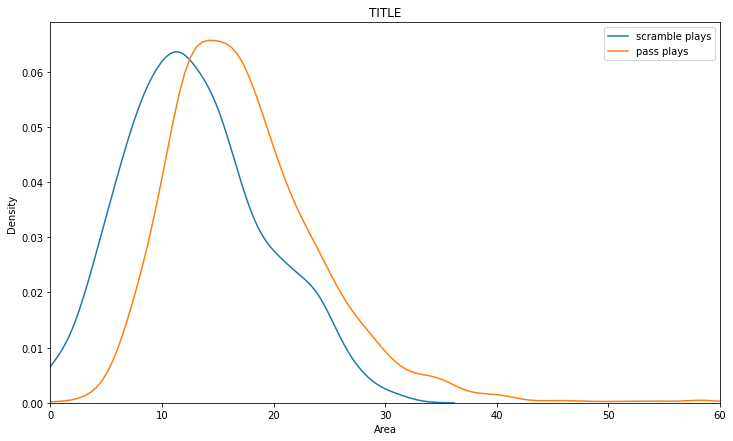

In [30]:
import seaborn as sns
plt.figure(figsize =(12,7))
plt.title('Comparison of area distributions')
sns.kdeplot(scramble_plays_wo_PA.Acrit, label = 'scramble plays')
sns.kdeplot(pass_plays_wo_PA.Ae, label = 'pass plays')
plt.xlabel("Area")
plt.ylabel("Density")
plt.legend()
plt.xlim([0,60])
plt.show()

In [13]:
from scipy.stats import normaltest
from scipy.stats import ttest_ind
test = normaltest(scramble_plays_wo_PA.Acrit)
print(f"p-value for normality test Acrit on scramble plays : {test.pvalue}")
test = normaltest(pass_plays_wo_PA.Ae)
print(f"p-value for normality test Ae on pass plays : {test.pvalue}")

test = ttest_ind(scramble_plays_wo_PA.Acrit, pass_plays_wo_PA.Ae)
print(f"Statistic for T-test : {test.statistic}")
print(f"p-value for T-test : {test.pvalue}")

p-value for normality test Acrit on scramble plays : 2.76525565533729e-07
p-value for normality test Ae on pass plays : 0.0
Statistic for T-test : -19.229025698822518
p-value for T-test : 1.7792838886825697e-79


# Is characteristic area characteristic of the teams passing game?

In [14]:
print(f'Total n° of plays : {len(df_play)}')
plays_w_features = pd.merge(df_area_features,df_play,how="left",on = ["playId","gameId"])
print(f'n° of plays in study: {len(plays_w_features)}')
plays_w_features_wo_PA = plays_w_features[plays_w_features.pff_playAction == 0]
print(f'n° of plays w/o play action : {len(plays_w_features_wo_PA)}')
print(plays_w_features_wo_PA.columns)



Total n° of plays : 8557
n° of plays in study: 7574
n° of plays w/o play action : 5772
Index(['playId', 'gameId', 'event', 'te', 'Ae', 'tc', 'Ac', 'tsnap',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1',
       'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType'],
      dtype='object')


In [15]:
means_df = plays_w_features_wo_PA.groupby("possessionTeam").mean().reset_index()
means_df

/tmp/ipykernel_6058/516944232.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,possessionTeam,playId,gameId,te,Ae,tc,Ac,tsnap,quarter,down,...,preSnapVisitorScore,penaltyYards,prePenaltyPlayResult,playResult,foulNFLId1,foulNFLId2,foulNFLId3,absoluteYardlineNumber,defendersInBox,pff_playAction
0,ARI,1982.971831,2.021098e+09,29.598592,20.777354,19.281690,29.524046,5.077465,2.380282,2.211268,...,13.584507,6.733333,7.704225,8.492958,44373.933333,NaN,NaN,58.732394,5.535211,0.0
1,ATL,2270.403141,2.021097e+09,27.104712,14.698778,16.649215,23.752367,5.146597,2.617801,2.188482,...,11.130890,6.894737,4.853403,5.382199,45524.157895,NaN,NaN,61.099476,5.827225,0.0
2,BAL,2350.700599,2.021098e+09,32.658683,18.325481,21.347305,28.218412,5.808383,2.826347,2.065868,...,15.988024,-3.750000,6.113772,5.778443,42746.250000,NaN,NaN,57.526946,5.592814,0.0
3,BUF,2095.926554,2.021096e+09,30.107345,21.364568,19.706215,32.439239,6.135593,2.463277,1.943503,...,8.903955,-1.666667,6.858757,6.361582,44315.750000,44759.333333,NaN,59.248588,5.689266,0.0
4,CAR,2320.263158,2.021098e+09,30.013158,14.893541,18.894737,27.003183,5.250000,2.692982,2.175439,...,8.442982,3.238095,5.447368,5.495614,46159.857143,NaN,NaN,60.276316,5.925439,0.0
5,CHI,2087.481928,2.021098e+09,29.409639,15.807504,17.518072,25.553992,5.180723,2.590361,2.253012,...,6.030120,11.428571,4.530120,5.036145,45355.285714,NaN,NaN,58.180723,5.662651,0.0
6,CIN,1874.661458,2.021098e+09,27.713542,16.752054,16.802083,24.747599,5.218750,2.421875,2.114583,...,10.083333,4.937500,7.484375,7.494792,44918.500000,43694.000000,NaN,59.562500,5.776042,0.0
7,CLE,1906.530488,2.021098e+09,30.829268,20.232775,20.993902,30.763264,5.091463,2.371951,2.207317,...,11.317073,-2.400000,4.969512,4.689024,46824.500000,NaN,NaN,56.835366,5.890244,0.0
8,DAL,2237.114943,2.021097e+09,27.718391,14.624271,17.235632,23.822373,6.609195,2.522989,2.120690,...,11.477011,1.190476,7.695402,7.045977,43827.761905,47302.333333,NaN,60.873563,6.057471,0.0
9,DEN,2247.256831,2.021099e+09,29.628415,14.590812,17.519126,22.990273,5.289617,2.814208,2.136612,...,10.901639,1.800000,6.584699,6.442623,47870.733333,NaN,NaN,64.672131,5.907104,0.0


In [16]:
fig_bar_plot_team(means_df, 'Ac', 'possessionTeam', y_legend = "Mean max. pocket area", ascending_metric = False, imagette_size = 2)

In [18]:
means_df = plays_w_features_wo_PA[plays_w_features_wo_PA.event == 'pass'].groupby("possessionTeam").mean().reset_index()
fig_bar_plot_team(means_df, 'te', 'possessionTeam', y_legend = "Max. pocket area", ascending_metric = False, imagette_size = 2)

/tmp/ipykernel_222639/4083184720.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [15]:
formations_df = plays_w_features_wo_PA.groupby("offenseFormation").mean().reset_index()

/tmp/ipykernel_222639/3416141354.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [19]:
for formation in plays_w_features.offenseFormation.unique():
    print(formation, len(plays_w_features[plays_w_features.offenseFormation == formation]))

SHOTGUN 4865
EMPTY 1222
SINGLEBACK 1059
I_FORM 263
JUMBO 25
PISTOL 133
nan 0
WILDCAT 1


In [16]:
for formation in plays_w_features_wo_PA.offenseFormation.unique():
    print(formation, len(plays_w_features_wo_PA[plays_w_features_wo_PA.offenseFormation == formation]))

SHOTGUN 4278
EMPTY 1218
SINGLEBACK 163
PISTOL 58
I_FORM 47
nan 0
JUMBO 3
WILDCAT 1
